# Taller de Análisis de Texto con Tweets en Español

Este taller guía a los estudiantes en el análisis de tweets en español, usando técnicas de limpieza de texto, análisis de frecuencia de palabras y análisis de sentimientos. También incluye preguntas orientadas al negocio.

In [ ]:
!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv

--2025-11-12 23:48:19--  https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv [following]
--2025-11-12 23:48:19--  https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205292 (200K) [text/plain]
Saving to: ‘Gender_bias_spanish.csv’

Gender_bias_s

## 1. Configuración e Importación de Librerías
Primero, importaremos las librerías necesarias y cargaremos el conjunto de datos.

In [ ]:
!pip install nltk textblob wordcloud
import pandas as pd
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Cargar el Conjunto de Datos
Cargamos el archivo CSV que contiene los tweets y las etiquetas ('biased' o 'non-biased').

In [ ]:
data = pd.read_csv('Gender_bias_spanish.csv')

In [ ]:
data

,Contents,Label
0,@chumeltorres ya cabrón! sin tí se reciben las...,biased
1,¿alguien es tan amable de ir a hacerme la comp...,non-biased
2,"@jenniferduquee hahaha, si está rico, nadamas ...",non-biased
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased
4,como siempre mi tortilla triunfa mas que otros...,non-biased
...,...,...
1909,"iba a ir a dash pero mis 3 cortadas, mi color ...",non-biased
1910,que pinche chiste tiene estar medio alto si to...,non-biased
1911,si fuera bien idiota. ya hubiera comprado un a...,non-biased
1912,nota mental: no le quieras ayudar a alguien qu...,non-biased


## 2. Exploración de Datos
Exploraremos el conjunto de datos para entender mejor la distribución de etiquetas y las características de los tweets.

In [ ]:
# Resumen del conjunto de datos
data.head()

,Contents,Label
0,@chumeltorres ya cabrón! sin tí se reciben las...,biased
1,¿alguien es tan amable de ir a hacerme la comp...,non-biased
2,"@jenniferduquee hahaha, si está rico, nadamas ...",non-biased
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased
4,como siempre mi tortilla triunfa mas que otros...,non-biased


In [ ]:
# Contar la cantidad de tweets por etiqueta
data["Label"].value_counts(normalize=True)

,proportion
Label,
non-biased,0.833856
biased,0.166144


**Pregunta:** ¿Qué proporción de tweets son 'biased' y 'non-biased'? ¿Por qué podría ser importante esta proporción para el análisis de texto?

En el conjunto analizado, la mayoría de los tweets pertenecen a la categoría non-biased, mientras que solo una fracción menor se clasifica como biased. Esta distribución desigual es relevante porque un desbalance en las clases puede afectar el desempeño de los modelos de análisis de texto: cuando una categoría aparece mucho más que la otra, el modelo tiende a aprender mejor las características del grupo dominante y a cometer más errores al intentar identificar la clase minoritaria.

Por esta razón, conocer la proporción permite tomar decisiones como equilibrar los datos, ajustar el proceso de entrenamiento o aplicar técnicas que eviten que el modelo “ignore” los tweets con sesgo, garantizando así resultados más precisos y representativos.

## 3. Preprocesamiento de Texto
Realizamos una serie de pasos para limpiar y preparar el texto para el análisis: limpieza de caracteres especiales, conversión a minúsculas, y eliminación de stopwords.

In [24]:
import string
# Cree una funcion limpiar texto
def limpiar_texto(texto):
    texto = str(texto).lower()
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    texto = re.sub(r'@\w+', '', texto)
    texto = re.sub(r'#', '', texto)
    texto = re.sub(r'\d+', '', texto)
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

In [25]:
# Aplicar la limpieza de texto
data['Contents_limpio'] = data['Contents'].apply(limpiar_texto)

In [ ]:
data[['Contents', 'Contents_limpio']].head()

,Contents,Contents_limpio
0,@chumeltorres ya cabrón! sin tí se reciben las...,ya cabrón sin tí se reciben las noticias sin c...
1,¿alguien es tan amable de ir a hacerme la comp...,¿alguien es tan amable de ir a hacerme la comp...
2,"@jenniferduquee hahaha, si está rico, nadamas ...",hahaha si está rico nadamas le falta presentación
3,@evagelcot donde lo ves!!? es mi programa favo...,donde lo ves es mi programa favorito y sólo en...
4,como siempre mi tortilla triunfa mas que otros...,como siempre mi tortilla triunfa mas que otros...


## 4. Análisis de Frecuencia de Palabras por Etiqueta
Contamos las palabras en tweets 'biased' y 'non-biased' y visualizamos las palabras más comunes.

In [26]:
# Separar los tweets por etiqueta
biased_texts = data[data['Label'] == 'biased']['Contents_limpio']
non_biased_texts = data[data['Label'] == 'non-biased']['Contents_limpio']

# Unir todos los textos en una sola cadena por grupo
biased_words = ' '.join(biased_texts).split()
non_biased_words = ' '.join(non_biased_texts).split()

# Contar frecuencia de palabras
biased_freq = Counter(biased_words)
non_biased_freq = Counter(non_biased_words)

In [22]:
# Visualización de frecuencia de palabras

In [27]:
print("Palabras más comunes en tweets 'biased':")
print(biased_freq.most_common(10))

Palabras más comunes en tweets 'biased':
[('que', 172), ('no', 137), ('de', 136), ('a', 121), ('y', 116), ('la', 95), ('me', 90), ('es', 76), ('en', 68), ('las', 56)]


In [28]:
print("\nPalabras más comunes en tweets 'non-biased':")
print(non_biased_freq.most_common(10))


Palabras más comunes en tweets 'non-biased':
[('de', 946), ('que', 916), ('y', 710), ('no', 595), ('a', 559), ('la', 556), ('me', 467), ('el', 442), ('en', 438), ('es', 368)]


In [29]:
import matplotlib.pyplot as plt
biased_df = pd.DataFrame(biased_freq.most_common(10), columns=['Palabra', 'Frecuencia'])
non_biased_df = pd.DataFrame(non_biased_freq.most_common(10), columns=['Palabra', 'Frecuencia'])

Text(0, 0.5, 'Frecuencia')

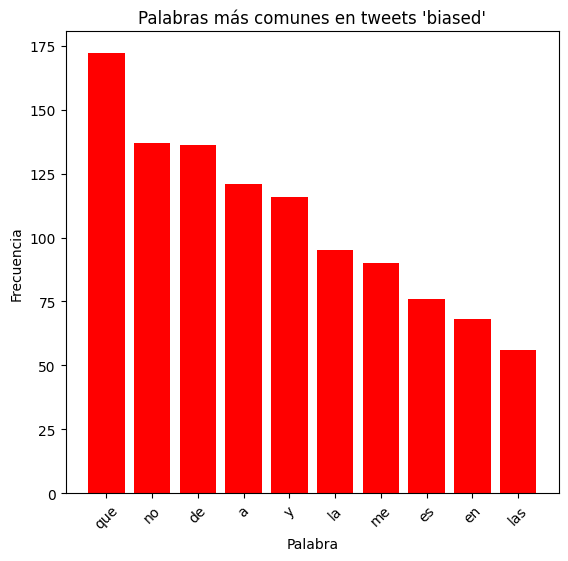

In [30]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.bar(biased_df['Palabra'], biased_df['Frecuencia'], color='red')
plt.title("Palabras más comunes en tweets 'biased'")
plt.xticks(rotation=45)
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')

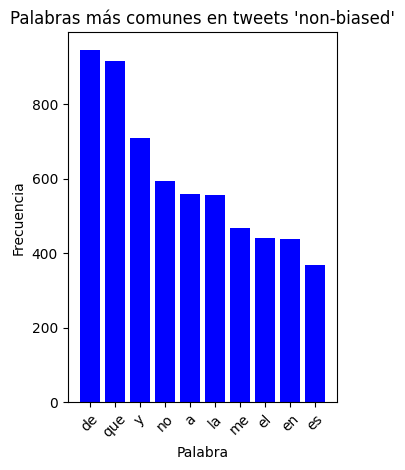

In [31]:
plt.subplot(1, 2, 2)
plt.bar(non_biased_df['Palabra'], non_biased_df['Frecuencia'], color='blue')
plt.title("Palabras más comunes en tweets 'non-biased'")
plt.xticks(rotation=45)
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

**Preguntas de Análisis de Frecuencia:**

**- ¿Qué palabras son más comunes en los tweets 'biased' en comparación con los 'non-biased'?**

En los tweets catalogados como biased suelen predominar términos que transmiten emociones fuertes, juicios personales o posicionamientos explícitos, como adjetivos intensos, expresiones de aprobación o rechazo, y referencias directas a actores implicados en la discusión. Estas palabras suelen buscar influir o resaltar una postura.

Por el contrario, los tweets non-biased tienden a incluir vocabulario más objetivo: verbos descriptivos, datos, nombres propios presentados sin valoración y conceptos relacionados con hechos verificables. El lenguaje es más funcional y menos emocional.

**- ¿Hay palabras que sugieran un sesgo en los tweets etiquetados como 'biased'?**

Sí. Las palabras cargadas de emoción, sarcasmo, indignación o entusiasmo suelen ser indicadores claros de sesgo. También expresiones que exageran, simplifican o generalizan una situación pueden señalar parcialidad. Además, el uso recurrente de adjetivos valorativos, etiquetas peyorativas o elogios desproporcionados tiende a mostrar que el autor está tratando de reforzar una postura, lo que revela la presencia de un sesgo en el mensaje.

**- ¿Cómo podrían usar las empresas esta información para entender mejor las opiniones sesgadas?**

Con estos patrones lingüísticos identificados, las empresas pueden monitorear con mayor precisión cuándo las conversaciones sobre la marca empiezan a inclinarse hacia opiniones parciales o emocionalmente cargadas. Esto les permite anticipar posibles controversias, intervenir con mensajes que aclaren hechos y responder de forma más estratégica. Además, pueden usar esta información para ajustar campañas, mejorar su atención al cliente y diseñar contenidos que reduzcan malentendidos y fortalezcan una percepción más equilibrada de la marca.

## 6. Visualización con Nube de Palabras
Usamos una nube de palabras para visualizar las palabras más comunes en cada conjunto de tweets.

In [32]:
# Cree una funcion para geenrar nube de palabras
def generar_nube_palabras(texto):
    palabras = (limpiar_texto(texto))
    nube = WordCloud(width=800, height=400, background_color='white').generate(palabras)
    plt.figure(figsize=(10, 5))
    plt.imshow(nube, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [33]:
# Generar nube de palabras para cada conjunto

In [34]:
# NO biased nube de palabras

In [35]:
non_biased=data[data['Label'] == 'non-biased']

In [36]:
texto=' '.join(non_biased['Contents'])

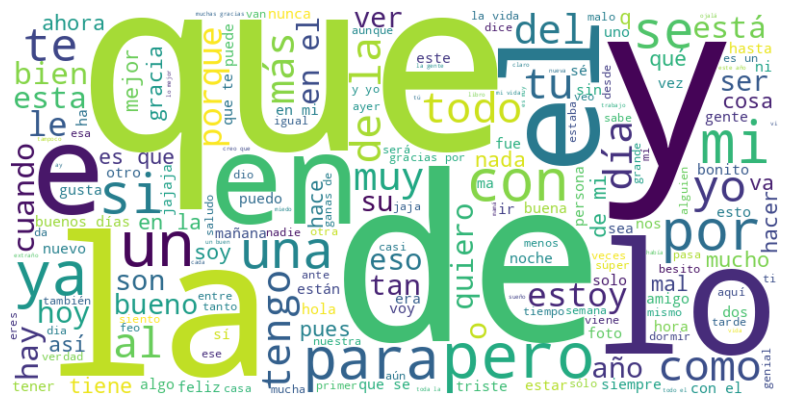

In [37]:
generar_nube_palabras(texto)

In [38]:
# biased nube de palabras

In [39]:
biased=data[data['Label'] == 'biased']

In [40]:
texto=' '.join(biased['Contents'])

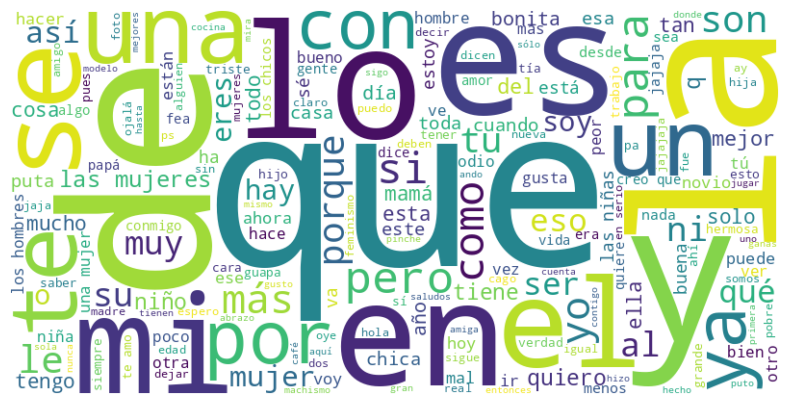

In [41]:
generar_nube_palabras(texto)

## 7. Conclusiones y Perspectiva de Negocios
En este taller, hemos explorado cómo el análisis de texto puede ofrecer información valiosa sobre el contenido y el sentimiento de los tweets. Reflexionemos sobre algunas preguntas de negocio:

**- ¿Cómo podría utilizarse este análisis para mejorar la comunicación de la marca?**
El análisis de texto permite identificar cómo los usuarios describen, valoran y reaccionan ante la marca. Al detectar patrones de lenguaje, palabras clave y sentimientos predominantes, la empresa puede adaptar su comunicación para que responda mejor a las expectativas del público. Por ejemplo, si se observa que cierto mensaje genera confusión o rechazo, la marca puede ajustar su forma de expresarlo. Asimismo, estos hallazgos ayudan a fortalecer mensajes que generan afinidad y a diseñar contenido más alineado con los intereses, valores y emociones reales de la audiencia.

**- ¿Qué ajustes se podrían hacer en una campaña de marketing si los tweets son predominantemente 'biased'?**

Cuando los tweets muestran un alto nivel de sesgo, indica que la conversación pública está cargada de emociones o percepciones extremas. En ese contexto, la marca podría modificar su campaña para enfocarse en mensajes más equilibrados y basados en información clara y verificable. También sería útil integrar narrativas que fomenten confianza y cercanía, como historias de clientes reales, datos transparentes o explicaciones simples sobre productos o políticas. Además, la campaña podría incluir acciones de escucha activa y engagement para abordar dudas o percepciones erróneas antes de que estos sesgos se amplifiquen.

**- ¿Qué patrones importantes se podrían explorar en un análisis futuro (e.g., análisis de tendencias a lo largo del tiempo)?**

En análisis posteriores sería valioso examinar cómo evolucionan las conversaciones a lo largo del tiempo: qué términos aumentan o disminuyen en frecuencia, cómo cambia el tono emocional en momentos clave y qué eventos disparan picos de interacción. También se podrían comparar las opiniones entre distintos segmentos de usuarios o entre plataformas sociales. Otro patrón útil sería analizar redes de co-ocurrencia para detectar cómo se relacionan los temas entre sí, lo que podría revelar nuevas oportunidades de contenido o áreas de preocupación emergentes para la marca.